SUJET 7 - TF-IDF ( par Benslimane, Sefraoui, Rekik, Baccar)      

**Sentiment Analysis for Financial News**.

Ce fichier .ipynb contient beaucoup de commentaires et d'explications sur nos méthodes. Nous l'avons écrit de sorte à ce qu'il fasse office aussi de rapport et non pas simplement de code python commenté. (meme si on a fait un rapport en .pdf)


----------------------------------------CONSIGNES


•Choix des données: Sentiment Analysis for Financial News


•Étapes principales du code:

  Présenter les principes de TF-IDF, donner des exemples de TF-IDF.
  
  Tester différents encodages de textes sur un (ou deux) modèle(s) de classification, par exemple, un modèle naïve bayésienne ou un réseau de neurones. Nous on va faire sur Modèle naïve bayésienne puis sur un réseau de neurones 

  Présenter vos résultats et donner une conclusion.


•Étapes principales du rapport:

  Présenter les données (features, labels) et la problématique (e.g. suppression des données, suppression des features, les raisons ...)

  Présenter la / les méthode(s) d’apprentissage que vous avez considérées (e.g. comment vous calibrez le ou les (hyper-)paramètres ...)

  Une conclusion présentant les résultats de votre étude (de manière critique) (e.g. comparer les méthodes; proposer des pistes d’amélioration ...)
  
  La qualité de la rédaction et l’orthographe seront prises en compte dans la note (e.g. donner des titres aux graphiques, commenter les figures et tableaux ...)


•Commentaires sur le code (très important) :
  Ecrire les commentaires dans le fichier .ipynb
  Expliquer les paramètres, les attributs des fonctions utilisées


•Donner les sources (Kaggle, Wikipedia, Sklearn)




----------------------------------------PACKAGES


In [1]:
import math
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import pygal as py
import matplotlib 
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from IPython.display import display, Math
from IPython.display import display, HTML


from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split



----------------------------------------LE PRINCIPE DE TF-IDF


**Qu'est ce que le TF-IDF ?**



Le TF-IDF (de l'anglais term frequency-inverse document frequency) est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes. 
Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. 
Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus. 
Des variantes de la formule originale sont souvent utilisées dans des moteurs de recherche pour apprécier la pertinence d'un document en fonction des critères de recherche de l'utilisateur.


La fréquence inverse de document (inverse document frequency) est une mesure de l'importance du terme dans l'ensemble du corpus. Dans le schéma TF-IDF, elle vise à donner un poids plus important aux termes les moins fréquents, considérés comme plus discriminants. Elle consiste à calculer le logarithme (en base 10 ou en base 21) de l'inverse de la proportion de documents du corpus qui contiennent le terme :

\begin{equation}
\mathrm{idf_{i}} = \log \frac{|D|}{|\{d_{j}:t_{i}\in d_{j}\}|}
\end{equation}
où :
$|D|$: nombre total de documents dans le corpus

$|\{d_{j}:t_{i}\in d_{j}\}|$: l'ensemble des documents où le terme $t_{i}$ apparaît (c'est-à-dire $n_{i,j}\neq 0$) 

Finalement, le poids s'obtient en multipliant les deux mesures :

$\mathrm{tfidf_{i,j}} = \mathrm{tf_{i,j}} \cdot \mathrm{idf_{i}}$




**Exemples d'application de TF-IDF fortement inspiré de https://fr.wikipedia.org/wiki/TF-IDF**


On prend ce corpus de 3 textes pour l'exemple
| Document 1 | Document 2 | Document 3 |
| --- | --- | --- |
| Son nom est célébré par le bocage qui frémit, et par le ruisseau qui murmure, les vents l’emportent jusqu’à l’arc céleste, l’arc de grâce et de consolation que sa main tendit dans les nuages. | À peine distinguait-on deux buts à l’extrémité de la carrière : des chênes ombrageaient l’un, autour de l’autre des palmiers se dessinaient dans l’éclat du soir. | Ah ! le beau temps de mes travaux poétiques ! les beaux jours que j’ai passés près de toi ! Les premiers, inépuisables de joie, de paix et de liberté ; les derniers, empreints d’une mélancolie qui eut bien aussi ses charmes. |



**Calcul de TF**

\begin{equation*}
\mathrm{TF}(t) = \frac{\text{Nombre d'apparitions du terme } t \text{ dans le document}}{\text{Nombre total de termes dans le document}}
\end{equation*}

avec ici

\begin{equation*}
\mathrm{tf}{1,1} = \frac{n_{1,1}}{\sum_k n_{k,1}} = \frac{2}{38} \approx 0.0526 \
\end{equation*}

où $n_{1,1}$ représente le nombre d'apparitions du terme $t$ (dans ce cas, le terme est "l") dans le document et $\sum_k n_{k,1}$ représente le nombre total de termes dans le document.

(remarque ici on ne compte par les signes du type ; , ')

**Calcul de IDF**

\begin{equation}
\mathrm{idf_{1}} = \log (\frac{|D|}{|{d_{j}:t_{i}\in d_{j}}|}) = \log (\frac{3}{2})  \approx 0.1760 \
\end{equation}




**Calcul du TF-IDF**

\begin{align*}

\mathrm{tfidf_{1,1}} &= \frac{2}{38} \cdot \log \frac{3}{2} \approx 0.0092 \


\mathrm{|tfidf_{1,2}} &= 0 \cdot \log \frac{3}{2} = 0 \


\mathrm{|tfidf_{1,3}} &= \frac{1}{40} \cdot \log \frac{3}{2} \approx 0.0044


\end{align*}

Ici $\mathrm{tfidf_{i,j}}$ représente le score TF-IDF pour le terme $t_i$ dans le document $d_j$. 

Comme le score TF-IDF pour le premier document est le plus élevé, il est considéré comme le plus pertinent.

Pour clôre cette exemple, on va l'implémenter en code.


In [2]:
# Ecriture de notre corpus composé ici de 3 documents
doc1 = "Son nom est célébré par le bocage qui frémit, et par le ruisseau qui murmure, les vents l’emportent jusqu’à l’arc céleste, l’arc de grâce et de consolation que sa main tendit dans les nuages."
doc2 = "À peine distinguait-on deux buts à l’extrémité de la carrière : des chênes ombrageaient l’un, autour de l’autre des palmiers se dessinaient dans l’éclat du soir."
doc3 = "Ah ! le beau temps de mes travaux poétiques ! les beaux jours que j’ai passés près de toi ! Les premiers, inépuisables de joie, de paix et de liberté ; les derniers, empreints d’une mélancolie qui eut bien aussi ses charmes."

corpus = [doc1, doc2, doc3]

# Paramètres de l'exemple
d = 1
t = "qui"

# On enleve tous les caractères qui ne sont pas des mots
corpus = [doc.lower().replace("'", "").replace(".", "").replace(",", "").replace("!", "").replace("?", "").replace(";", "").replace(":", "").split() for doc in corpus]
tfidf = []

# Calcul de TF
tf = corpus[d-1].count(t) / len(corpus[d-1])

# Calcul de IDF
doc_with_t = sum([1 for doc in corpus if t in doc])
idf = math.log(len(corpus) / doc_with_t)

# Calcul de TF-IDF
tfidf.append(tf * idf)

# Affichage des résultats
print("TF : ", tf)
print("IDF : ", idf)
print("TF-IDF : ", tfidf[0])


TF :  0.058823529411764705
IDF :  0.4054651081081644
TF-IDF :  0.023850888712244965


On retrouve bien la bonne valeur pour la TF-IDF ! Ceci clôt notre partie de présentation de la TF-IDF.


----------------------------------------PRÉSENTATION DE LA PROBLÉMATIQUE

Le but de ce projet est de classifier si un document d'opinion exprime un sentiment positif, négatif ou neutre dans son ensemble. 
Par exemple, en se basant sur une critique de produit, le système détermine si la critique exprime une opinion globale positive ou négative sur le produit. 
Cette tâche est communément appelée classification de sentiment à l'échelle du document. Cette analyse suppose que chaque document exprime des opinions sur une seule entité (par exemple, un seul produit). 



----------------------------------------PRÉSENTATION DES DONNÉES


Notre jeu de données se nomme: all-data-csv et a pour titre **Sentiment Analysis for Financial News**.

Il contient les sentiments des titres de l'actualité financière du point de vue d'un investisseur individuel.

On voit que les données sont composées de 4845 lignes et 2 de colonnes qui que l'on va créer "sentiment" et "news"


In [3]:
#Récupération des données brutes

df=pd.read_csv("all-data.csv",engine="python",encoding="ISO-8859-1")
df

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [4]:
#Modification du format des données 

col1=df.keys()[0]
col2=df.keys()[1]
df2=pd.DataFrame([[col1, col2]], columns=list([col1,col2]), index=[4845])
df=df.append(df2, ignore_index=True).set_axis(['sentiment', 'news'], axis=1, inplace=False)
df


/var/folders/m1/k7ywl20s5t90qkylbxspkw080000gn/T/ipykernel_73642/3230480329.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(df2, ignore_index=True).set_axis(['sentiment', 'news'], axis=1, inplace=False)
/var/folders/m1/k7ywl20s5t90qkylbxspkw080000gn/T/ipykernel_73642/3230480329.py:6: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df=df.append(df2, ignore_index=True).set_axis(['sentiment', 'news'], axis=1, inplace=False)


,sentiment,news
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...
4844,negative,Sales in Finland decreased by 10.5 % in Januar...


(Attention, on pourrait croire que notre phrase "According to Gran, the compagny ...." a eté supprimée mais elle passe tout simplement de notre première donnée à la derniere.)

**Maintenant pour avoir une idée de la distribution de nos données, faisons le plot suivant**

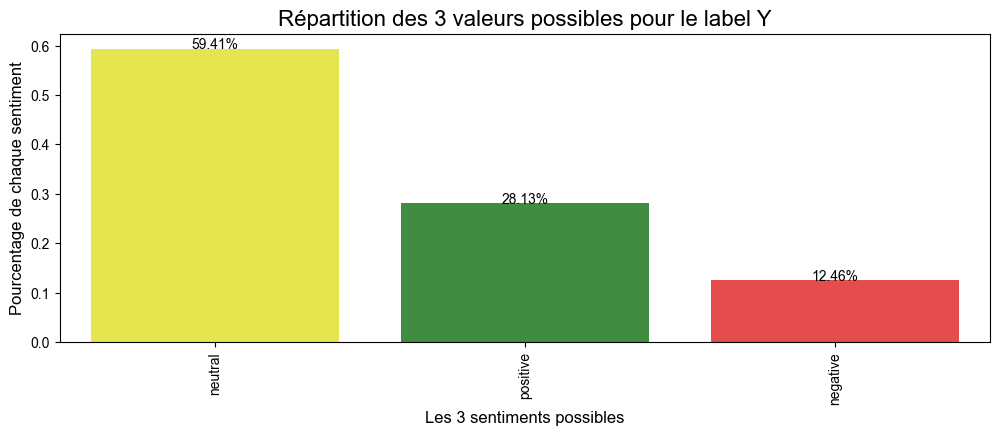

In [5]:
cnt_pro = df['sentiment'].value_counts()
total = cnt_pro.sum()

plt.figure(figsize=(12,4))
ax = sns.barplot(x=cnt_pro.index, y=cnt_pro.values/total, alpha=0.8, 
                 palette=["yellow", "green", "red"])

plt.ylabel('Pourcentage de chaque sentiment', fontsize=12)
plt.xlabel('Les 3 sentiments possibles', fontsize=12)
plt.xticks(rotation=90)

sns.set_style("whitegrid")

for i, val in enumerate(cnt_pro.values):
    ax.text(i, val/total, '{:.2%}'.format(val/total), color='black', ha="center")

plt.title('Répartition des 3 valeurs possibles pour le label Y', fontsize=16)


plt.show()

**On s'est aussi interessé à representer les mots qui ressortent le plus souvent. On a donc cherché à représenter nos données facilement sous la forme d'un Wordcloud comme le proposait un utilisateur Kaggle (voir reférences).**

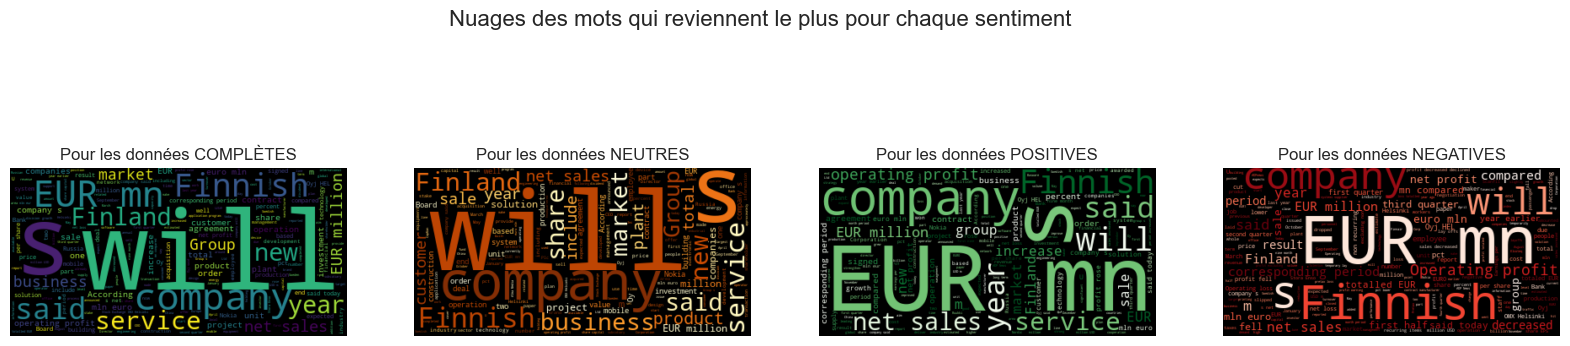

In [6]:
text = " ".join([x for x in df.news])

text_neutral = " ".join([x for x in df.loc[df.sentiment=='neutral', 'news']])
text_positive = " ".join([x for x in df.loc[df.sentiment=='positive', 'news']])
text_negative = " ".join([x for x in df.loc[df.sentiment=='negative', 'news']])

wordcloud = WordCloud(background_color='black').generate(text)
wordcloud_neutral = WordCloud(background_color='black', colormap='YlOrBr').generate(text_neutral)
wordcloud_positive = WordCloud(background_color='black', colormap='Greens').generate(text_positive)
wordcloud_negative = WordCloud(background_color='black', colormap='Reds').generate(text_negative)

fig, axs = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle('Nuages des mots qui reviennent le plus pour chaque sentiment', fontsize=16)

axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].set_title('Pour les données COMPLÈTES')
axs[0].axis('off')

axs[1].imshow(wordcloud_neutral, interpolation='bilinear')
axs[1].set_title('Pour les données NEUTRES')
axs[1].axis('off')

axs[2].imshow(wordcloud_positive, interpolation='bilinear')
axs[2].set_title('Pour les données POSITIVES')
axs[2].axis('off')

axs[3].imshow(wordcloud_negative, interpolation='bilinear')
axs[3].set_title('Pour les données NEGATIVES')
axs[3].axis('off')

plt.show()


----------------------------------------PRÉTAITEMENT DES DONNÉES




**a)Prétaitement des données**

Tout d'abord que notre dataset est de la forme   $D_N = \{(X_i,Y_i) \mid i = 1,\ldots,N\}$ tels que $(X_i,Y_i)$ iid de $(X,Y)$ appartenant à l'ensemble $X\times Y$ avec 
$Y=$\{0,1,2\}={"neutre","negatif","positif"}.

Transformons pour commencer les 3 valeurs possibles de notre label en 0, 1 ou 2 :






In [7]:
def func(df):
    if df == 'neutral':
        return 0
    elif df == 'negative':
        return 1
    else:
        return 2
#Ici on veille bien à travailler avec une copie de notre dataset pour ne pas le modifier 
df_copy=df.copy()
df_copy.head()
df_copy['target'] = df_copy.sentiment.apply(func)


df_copy



,sentiment,news,target
0,neutral,Technopolis plans to develop in stages an area...,0
1,negative,The international electronic industry company ...,1
2,positive,With the new production plant the company woul...,2
3,positive,According to the company 's updated strategy f...,2
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,2
...,...,...,...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...,1
4843,negative,Net sales of the Paper segment decreased to EU...,1
4844,negative,Sales in Finland decreased by 10.5 % in Januar...,1


On obtient donc notre nouveau dataset dans lequel on ajoute une colonne supplémentaire selon la valeur de "sentiment"

**b)Prétaitement des données**

On fait maintenant du word embedding, ie transformer chaque mot en vecteur. Pour cela on utilise TfidfVectorizer qui transforme des textes en une matrice de vecteurs de caractéristiques TF-IDF. TfidfVectorizer est capable de prendre en compte plusieurs paramètres, tels que la normalisation, le retrait des accents, la suppression des stop words, la pondération en fonction de la fréquence inverse du document...mais cette fonction ne supprime pas les caractères spéciaux ou les chiffres donc on va le faire nous même !

In [8]:
import re

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

print("---------------------------------------------")
print("Voici les textes AVANT prétraitement :")
print(df_copy['news'].head())

# Appliquer la fonction de prétraitement à chaque texte de la colonne 'news'
df_copy['news'] = df_copy['news'].apply(preprocess_text)

print("---------------------------------------------")
print("Voici les textes APRES prétraitement :")
print(df_copy['news'].head())

---------------------------------------------
Voici les textes AVANT prétraitement :
0    Technopolis plans to develop in stages an area...
1    The international electronic industry company ...
2    With the new production plant the company woul...
3    According to the company 's updated strategy f...
4    FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
Name: news, dtype: object
---------------------------------------------
Voici les textes APRES prétraitement :
0    technopolis plans to develop in stages an area...
1    the international electronic industry company ...
2    with the new production plant the company woul...
3    according to the company s updated strategy fo...
4    financing of aspocomp s growth aspocomp is agg...
Name: news, dtype: object


Maintenant on peut appliquer TfidfVectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ici l'utilisation de stop_words='english' va permettre d'enlever les mot de liaison du type "or" "and" qui sont inutiles

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_copy['news'])

print(X)



  (0, 7059)	0.12471596814158703
  (0, 7741)	0.2627048486589856
  (0, 8164)	0.2559802314780698
  (0, 8132)	0.24370659833418182
  (0, 1519)	0.27736685762395114
  (0, 9085)	0.2559802314780698
  (0, 1460)	0.18353558825099747
  (0, 3566)	0.32820868256042857
  (0, 5628)	0.19383443274955472
  (0, 4987)	0.29505334225887403
  (0, 7691)	0.2539730900581329
  (0, 426)	0.20845820949002603
  (0, 7711)	0.29505334225887403
  (0, 2003)	0.260332566063986
  (0, 6036)	0.22684977047365312
  (0, 8137)	0.260332566063986
  (1, 6774)	0.18212465484235593
  (1, 6149)	0.2913185472508524
  (1, 1829)	0.22242487162205146
  (1, 9080)	0.22456308799009733
  (1, 5520)	0.18534377287701653
  (1, 6505)	0.2913185472508524
  (1, 1631)	0.2609610521262628
  (1, 4422)	0.20763899845873962
  (1, 2255)	0.16748635811336857
  :	:
  (4843, 7245)	0.22950720562192678
  (4843, 7221)	0.3627631029799606
  (4843, 5770)	0.1837242039094244
  (4843, 1893)	0.1813815514899803
  (4843, 6973)	0.17189543668133941
  (4843, 5099)	0.5210810085496309


On obtient cette matrice creuse X. 
Chaque ligne de la forme (a, b) c de la matrice X signifie que : 

a=indice de la ligne dans la matrice X, c'est-à-dire le document associé


b=indice de la colonne dans la matrice X, c'est-à-dire le terme associé


c=pondération TF-IDF du terme a dans le document b

Donnons maintenant un exemple concret du fonctionnement de TfidfVectorizer



In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = [
    "Ceci est le premier document.",
    "Ceci est le deuxième document.",
    "Et ceci est le troisième.",
    "Est-ce le premier document?",
]

# Adapter le vectoriseur au corpus
vectorizer2 = TfidfVectorizer(stop_words='english')

vectorizer2.fit(corpus)

# Exemple de texte à transformer
texte = "Ceci est un nouveau texte à vectoriser."

# Transformer le texte en utilisant le vectoriseur adapté
vecteur_texte = vectorizer2.transform([texte])

# Afficher le texte original et sa représentation vectorielle
print("Texte original :")
print(texte)
print("\nReprésentation vectorielle :")
print(vecteur_texte)


Texte original :
Ceci est un nouveau texte à vectoriser.

Représentation vectorielle :
  (0, 4)	0.632951942394233
  (0, 1)	0.7741910866313093


Pour bien comprendre le fonctionnenment de TfidfVectorizer interprétons la première ligne qui est:        

   (0, 4)	0.632951942394233

   
(0, 4) signifie que l'élément non nul se trouve à la ligne 0 et à la colonne 4 de la matrice. Cela signifie que le mot "texte" apparaît dans le texte et correspond à la 5ème colonne de la matrice X.La valeur 0.632951942394233 indique l'importance relative TF-IDF du mot "texte" dans le texte. 

Ceci clôt la partie de word embedding par méthode TD-IF. On peut remarquer qu'on aurait pu aussi utiliser la fonction TfidfTransformer pour faire la même chose dans les grandes lignes.



**Séparation du datatrain et du datatest**





On va découper `(X,y)` en l'ensemble d'entraînement et l'ensemble de test. 

In [11]:
y = df_copy['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



----------------------------------------MODÈLE NAIVE BAYÉSIENNE MULTINOMIAL


a)Tout d'abord commencons avec le paramètre de lissage par défault  $\alpha=1.0$ (un peu plus tard on implémentera une validation croisée pour trouver le paramètre de lissage optimal est 0.1)

In [12]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB

# Création du modèle
nb = MultinomialNB()       #Ici par défault le paramètre de lissage $\alpha=1.0$
nb.fit(X_train, y_train)     #On entraine notre modèle
y_pred = nb.predict(X_test)

Qu'en est-il de la qualité de notre prédiction ? Faisons une heatmap pour avoir une idée.

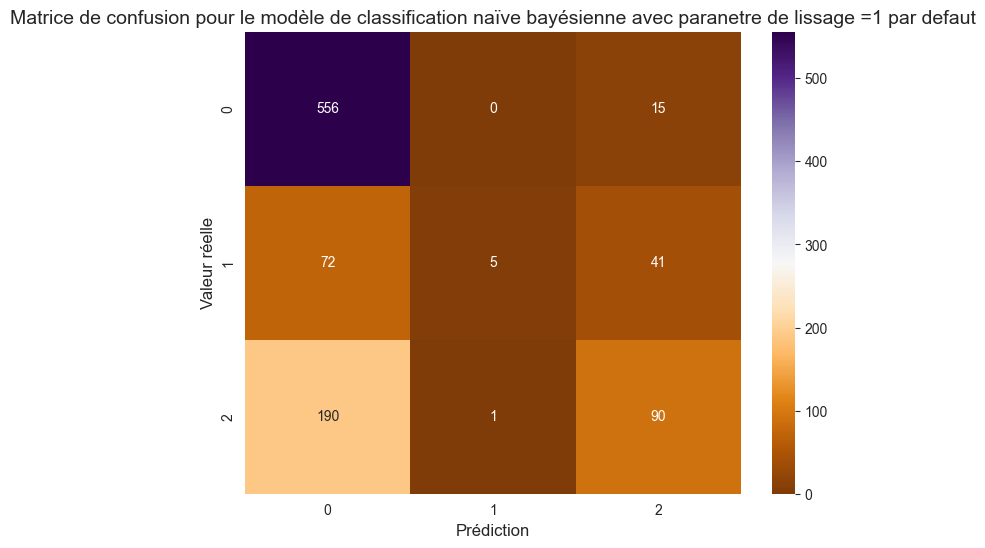

In [13]:
class_names = [0, 1,2]
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap='PuOr', fmt='g',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion pour le modèle de classification naïve bayésienne avec paranetre de lissage =1 par defaut', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Valeur réelle', fontsize=12)
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       571
           1       0.83      0.04      0.08       118
           2       0.62      0.32      0.42       281

    accuracy                           0.67       970
   macro avg       0.71      0.45      0.43       970
weighted avg       0.68      0.67      0.60       970



On obtient une assez bonne accurary de 0.67 et de bonnes prédictions pour les labels 0 et 2. En ce qui concerne la prédiction du label 1, celle-ci est moins précise en raison du faible effectif de 1 dans notre dataset. Piste: on pourrait alors pensez à rééchantillonner notre dataset pour éviter la surinterprétation des amplitudes surreprésentées mais on ne le fait pas.

**b)On cherche maintenant à optimiser l'hyperparamètre de lissage $\alpha$** : on procède par validation croisée

À quoi sert cet hyperparamètre ?

 Il agit comme un facteur d'ajustement qui permet d'ajouter un nombre positif aux comptages des caractéristiques pour chaque classe. Cela aide à éviter les problèmes de probabilité nulle (lorsqu'une caractéristique n'apparaît pas dans une classe particulière) et améliore la précision du modèle en réduisant le biais.

On va faire la validation croisée par K-folds puis par Leave-one-out comme au TP4 et on va comparer nos 2 résultats

Tout d'abord on faire la K-folds.

In [15]:
from sklearn.model_selection import GridSearchCV


param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}     # Définition des différentes valeurs de alpha à tester

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')   #  Validation croisée par K-folds avec K=5
grid_search.fit(X_train, y_train)

print("Meilleur score : ", grid_search.best_score_)
print("Meilleur paramètre : ", grid_search.best_params_)


Meilleur score :  0.6986584635849684
Meilleur paramètre :  {'alpha': 0.1}


On trouve que la paramètre de lissage alpha optimal =0.1. On peut donc fit de nouveau notre modèle avec ce paramètre pour retrouver les prédictions obtenues. Faisons le:

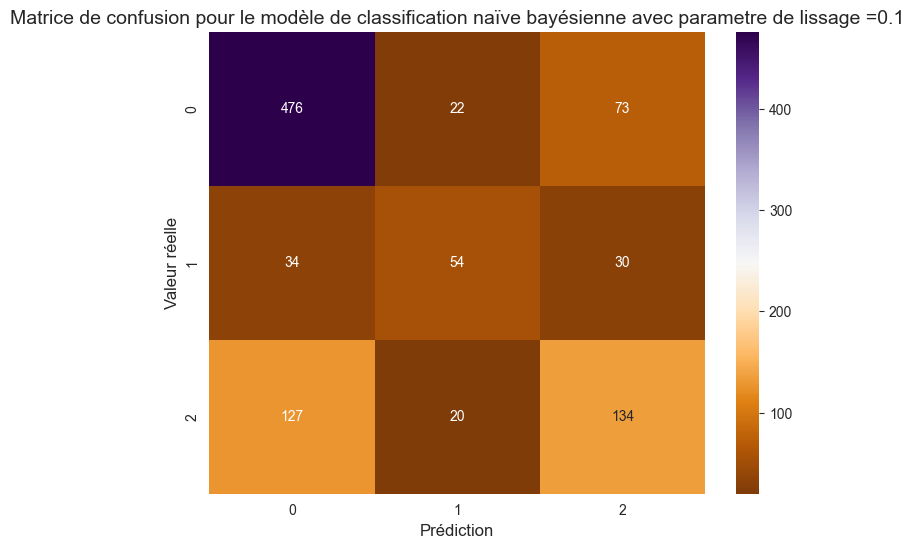

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       571
           1       0.56      0.46      0.50       118
           2       0.57      0.48      0.52       281

    accuracy                           0.68       970
   macro avg       0.63      0.59      0.60       970
weighted avg       0.67      0.68      0.68       970



In [16]:

nb_new = MultinomialNB(alpha=0.1)       
nb_new.fit(X_train, y_train)     
y_pred =nb_new.predict(X_test)
class_names = [0, 1,2]
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap='PuOr', fmt='g',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion pour le modèle de classification naïve bayésienne avec parametre de lissage =0.1', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Valeur réelle', fontsize=12)
plt.show()
print(classification_report(y_test, y_pred))

On constate donc que nos prédictions sont nettement meilleures avec ce nouveau paramètre de lissage. 

(Pas demmandé)Maintenant faisons la validation croisée par Leave-One-Out   (**attention l'execution prend environ 2 min, enlever les # si vous voulez executer**)

In [17]:


#from sklearn.model_selection import LeaveOneOut

#param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}     # Définition des différentes valeurs de alpha à tester


#grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=LeaveOneOut(), scoring='accuracy')   #  Validation croisée par Leave-One-Out
#grid_search.fit(X_train, y_train)

#print("Meilleur score : ", grid_search.best_score_)
#print("Meilleur paramètre : ", grid_search.best_params_)


On trouve par cette validation croisée par Leave-One-Out que le alpha optimal est: 0.1 ce qui est la meme valeur par K-folds !

on retrouve le paramètre par défaut alpha=0.1.
Testons maintenant notre modèle de classification avec alpha=0.1 optimal sur 3 nouveaux titre qu'on a nous même pris de CNBC NEWS, BBC et la commission EU pour voir les prédiction.


In [18]:
def predict_sentiment(text):
    text_vectorized = vectorizer.transform([text])
    sentiment_pred = nb_new.predict(text_vectorized)[0]
    if sentiment_pred == 0:
        return "NEUTRE"
    elif sentiment_pred == 1:
        return "NEGATIF"
    else:
        return "POSITIF"

new_text_1 = "A recession is coming — and stock markets won't come through it unscathed, strategist says. CNBC NEWS 2023"
print("Voici le premier titre : ", new_text_1)
print("La prédiction de sentiment pour le texte est :", predict_sentiment(new_text_1))

new_text_2 = "A famous market watcher who called the subprime mortgage crisis is warning that stocks are about to crash: It’s the highest probability since COVID"
print("Voici le deuxième titre : ", new_text_2)
print("La prédiction de sentiment pour le texte est :", predict_sentiment(new_text_2))

new_text_3 = "Winter 2022 Economic Forecast: Growth expected to regain traction after winter slowdown. European Commission 2023" 
print("Voici le dernier titre : ", new_text_3)
print("La prédiction de sentiment pour le texte est :", predict_sentiment(new_text_3))


Voici le premier titre :  A recession is coming — and stock markets won't come through it unscathed, strategist says. CNBC NEWS 2023
La prédiction de sentiment pour le texte est : NEUTRE
Voici le deuxième titre :  A famous market watcher who called the subprime mortgage crisis is warning that stocks are about to crash: It’s the highest probability since COVID
La prédiction de sentiment pour le texte est : NEGATIF
Voici le dernier titre :  Winter 2022 Economic Forecast: Growth expected to regain traction after winter slowdown. European Commission 2023
La prédiction de sentiment pour le texte est : POSITIF


On voit donc que notre modèle de classification marche assez bien. Mais on reste confrontés à certaines faiblesses: par exemple le terme "Great" de "Great Depression" fausse presque toujours nos prédicitons.

----------------------------------------MODÈLE PAR RÉSEAU DE NEURONES (optionnel normalement on devait coder soit la classification soit le reseau de neurones)


Tout d'abord on va créer le réseau de neurones multicouches avec le package Keras. 

On peut creer plusieurs types de réseaux de neurones mais on crée un réseau de neurones perceptron multicouche comme conseillé au Chapitre5 du Poly de Cours


Parlons un peu de la théorie derrière notre réseau de neurones: 

Tout d'abord la couche d'entrée:

Notre couche d'entrée va avoir un nombre de neurones égal au nombre de termes uniques dans la matrice TD-IDF précedemement obtenue. 


Maintenant parlons des couches cachées. On choisit L=2 pour commencer (on essayera d'optimiser cet hyperparamètre après) et chaque couche a une fonction d'activation ReLu definie par f(x) = max(0, x)


Pour finir la couche de sortie:

En ce qui concerne la couche de sortie, pusique nous sommes dans le cadre d'une prédiction multinomiale à 3 classes, elle aura un nombre de neurones égal à 3. On choisit la fonction d'activation softmax.

La sortie du réseau est une prédiction de $K=3$ probabilités conditionnelles $P(Y=k|X=x)$, $1\leq k\leq K$.

La prédiction de label pour une donnée $x\in X$ est $\operatorname{argmax}_{1\leq k\leq K} P(Y=k|X=x)$.


Ce paragraphe ci-dessous est extrait du poly de cours et résume le fonctionnement de notre réseau de neurones.

On utilise softmax $\varphi : \mathbb{R}^K \to (0,1)^K$ est définie par $\forall x = (x_1, ..., x_K) \in \mathbb{R}^K, \varphi(x)i := \frac{e^{x_i}}{\sum{j=1}^K e^{x_j}}, 1 \leq i \leq K$.

Ici le label est $ {\text{"neutre"=0, "positif"=2, "négatif"=2}}$, on utilise 3 neurones dans la couche de sortie 

et on calcule $z_{(L+1)}(x)i = \sum{} w_{(L+1)ij} a_{(L)j}(x) + b_{(L+1)i}$ 


 et  $a{(L+1)}(x)i = \frac{e^{z{(L+1)}(x)i}}{\sum{} e^{z_{(L+1)}(x)j}}, 1 \leq i \leq 3$. La prédiction de $P(Y=i|X=x)$ est donc $a{(L+1)}(x)_i$.








On peut maintenant creer notre réseau de neurones: (execution environ 1min30) en utilisant comme fonction de perte l'entropie croisee entre les labels réelles et les prédictions de probabilité du modèle RNN

In [19]:
import keras

# Convertir les données en tableaux Numpy
X_train = np.array(X_train.toarray())
X_test = np.array(X_test.toarray())
y_train = np.array(y_train)
y_test = np.array(y_test)

# Définir le modèle
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3)

# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Prédire les étiquettes pour les données de test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)



2023-05-31 23:57:13.218216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
85/85 [==============================] - 6s 51ms/step - loss: 0.9317 - accuracy: 0.5868 - val_loss: 0.8365 - val_accuracy: 0.5881
Epoch 2/20
85/85 [==============================] - 3s 37ms/step - loss: 0.7104 - accuracy: 0.6653 - val_loss: 0.7395 - val_accuracy: 0.6733
Epoch 3/20
85/85 [==============================] - 3s 32ms/step - loss: 0.4365 - accuracy: 0.8142 - val_loss: 0.7941 - val_accuracy: 0.6913
Epoch 4/20
85/85 [==============================] - 3s 37ms/step - loss: 0.2308 - accuracy: 0.9167 - val_loss: 0.8680 - val_accuracy: 0.7300
Epoch 5/20
85/85 [==============================] - 4s 48ms/step - loss: 0.1176 - accuracy: 0.9665 - val_loss: 1.1045 - val_accuracy: 0.7343
Epoch 6/20
85/85 [==============================] - 3s 33ms/step - loss: 0.0890 - accuracy: 0.9753 - val_loss: 1.2003 - val_accuracy: 0.7317
Epoch 7/20
85/85 [==============================] - 4s 46ms/step - loss: 0.0608 - accuracy: 0.9805 - val_loss: 1.2296 - val_accuracy: 0.7274
Epoch 8/20
85

On obtient cette courbe d'erreur de notre modèle ANN: 

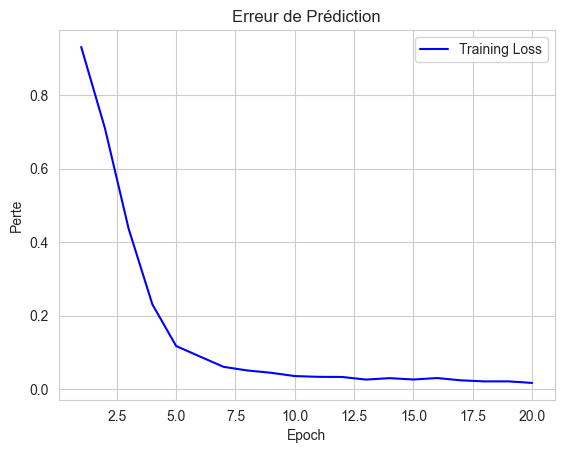

In [20]:
# on veille à conserver l'historique de la perte
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracer la courbe d'erreur de prédiction
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Erreur de Prédiction')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()




Maintenant interressons nous aux matrices de confusions obtenues:

[[484  23  64]
 [ 40  61  17]
 [114  15 152]]
              precision    recall  f1-score   support

     Neutral       0.76      0.85      0.80       571
    Negative       0.62      0.52      0.56       118
    Positive       0.65      0.54      0.59       281

    accuracy                           0.72       970
   macro avg       0.68      0.64      0.65       970
weighted avg       0.71      0.72      0.71       970



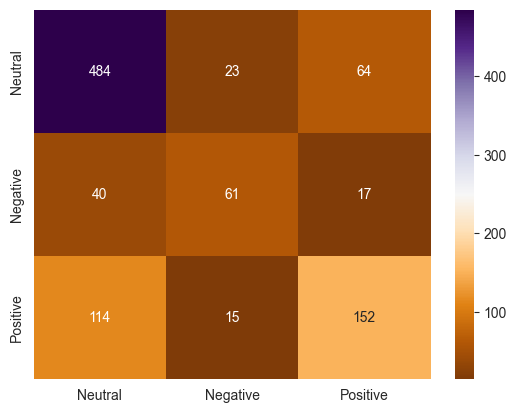

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=True, cmap='PuOr', fmt='g', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])

# Afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))


On obtient une bonne accuracy et de bonnes prédictions après avoir testé notre modèle ANN.

Testons notre réseau de neurones sur les 3 même titre de journaux que précedemment:

In [22]:
import numpy as np

def predict_sentiment(text):
    text = vectorizer.transform([text])
    text = np.array(text.toarray())
    text_pred = np.argmax(model.predict(text), axis=1)
    return text_pred

def print_sentiment_prediction(text, prediction):
    if prediction == 0:
        print(f"La prédiction de sentiment est : NEUTRE")
    elif prediction == 1:
        print(f"La prédiction de sentiment est : NEGATIF")
    else:
        print(f"La prédiction de sentiment  est : POSITIF")

new_text = "A recession is coming — and stock markets won't come through it unscathed, strategist says. CNBC NEWS 2023"
print("Testons le titre suivant:", new_text)
new_text_pred = predict_sentiment(new_text)
print_sentiment_prediction(new_text, new_text_pred)

new_text_2 = "A famous market watcher who called the subprime mortgage crisis is warning that stocks are about to crash: It’s the highest probability since COVID"
print("Voici le deuxième titre:", new_text_2)
new_text_2_pred = predict_sentiment(new_text_2)
print_sentiment_prediction(new_text_2, new_text_2_pred)

new_text_3 = "Winter 2022 Economic Forecast: Growth expected to regain traction after winter slowdown. European Commission 2023"
print("Voici le dernier titre:", new_text_3)
new_text_3_pred = predict_sentiment(new_text_3)
print_sentiment_prediction(new_text_3, new_text_3_pred)

Testons le titre suivant: A recession is coming — and stock markets won't come through it unscathed, strategist says. CNBC NEWS 2023
1/1 [==============================] - 0s 33ms/step
La prédiction de sentiment est : NEUTRE
Voici le deuxième titre: A famous market watcher who called the subprime mortgage crisis is warning that stocks are about to crash: It’s the highest probability since COVID
1/1 [==============================] - 0s 28ms/step
La prédiction de sentiment est : NEGATIF
Voici le dernier titre: Winter 2022 Economic Forecast: Growth expected to regain traction after winter slowdown. European Commission 2023
1/1 [==============================] - 0s 34ms/step
La prédiction de sentiment est : NEUTRE


En conclusion, on remarque une meilleure qualité de predictions pour notre modele de classification en comparaison avec le modele ANN. 

Ceci clôt notre projet !

**Références**

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

https://fr.wikipedia.org/wiki/TF-IDF

https://tfidf.com/

https://www.kaggle.com/code/mmmarchetti/sentiment-analysis-on-financial-news




